In [54]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
import networkx as nx

workpath = os.getcwd()
libpath = workpath + "/libs/"
figpath = workpath + "/figs/"
outpath = workpath + "/out/"
distpath = workpath + "/input/osm-primnet/"
grbpath = workpath + "/gurobi/"
homepath = workpath + "/input/load/121-home-load.csv"


sys.path.append(libpath)
from pyExtractlib import get_home_load,GetDistNet
from pySchedEVChargelib import compute_Rmat,Residence
from pyDrawNetworklib import DrawNodes,DrawEdges
print("Imported modules and libraries")

Imported modules and libraries


In [55]:
# Some constant inputs
sub = 121144
shft = 6
T = 24
initial = 0.5
final = 0.9
start = 11
end = 23

# Cost profile
COST = [0.078660]*5 + [0.095111]*10 + [0.214357]*3 + [0.095111]*6
COST = np.roll(COST,-shft).tolist()

# Ratings of EV charger
ratings = [800, 1000, 1200, 1600, 2000]
# Adoption percentages
adoptions = [10,20,30,40,50,60,70,80,90,100]
# Get input data
all_homes = get_home_load(homepath,shift=shft)
dist = GetDistNet(distpath,sub)
#res = [n for n in dist if dist.nodes[n]['label']=='H']
print("Loaded network")

# Area of interest where EV adoption is studied
xmin = -80.37217
ymin = 37.1993
wd = 0.010
ht = 0.005
xmax = xmin + wd
ymax = ymin + ht
res_interest = [n for n in dist if (xmin<=dist.nodes[n]['cord'][0]<=xmax) and (ymin<=dist.nodes[n]['cord'][1]<=ymax) \
               and dist.nodes[n]['label']=='H']
print("Area selected for EV adoption study")

Loaded network
Area selected for EV adoption study


In [56]:
def plot_network(ax,net,path=None,with_secnet=True,ev_home=[]):
    """
    """
    # Draw nodes
    DrawNodes(net,ax,label='S',color='dodgerblue',size=2000)
    DrawNodes(net,ax,label='T',color='green',size=25)
    DrawNodes(net,ax,label='R',color='black',size=2.0)
    if with_secnet: DrawNodes(net,ax,label='H',color='crimson',size=2.0)
    # Draw edges
    DrawEdges(net,ax,label='P',color='black',width=2.0)
    DrawEdges(net,ax,label='E',color='dodgerblue',width=2.0)
    if with_secnet: DrawEdges(net,ax,label='S',color='crimson',width=1.0)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    
    # Draw community of interest
    if len(ev_home) != 0:
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), wd, ht, linewidth=1.5, 
                                 edgecolor='blue', facecolor='none')
        # Add the patch to the Axes to denote the locality
        ax.add_patch(rect)
        # Add the nodes where EV adoption
        x_int = [dist.nodes[n]['cord'][0] for n in ev_home]
        y_int = [dist.nodes[n]['cord'][1] for n in ev_home]
        ax.scatter(x_int,y_int,s=100.0,c='blue')
    return ax

def draw_boxplot(df,ax=None,a=10,r=None):
    if ax == None:
        fig = plt.figure(figsize=(60,20))
        ax = fig.add_subplot(1,1,1)
    ax = sns.boxplot(x="hour", y="voltage", hue="group",
                 data=df, palette="Set3",ax=ax)
    if r==None:
        ax.set_title("EV adoption percentage: "+str(a)+"%",
                     fontsize=50)
    else:
        ax.set_title("EV adoption percentage: "+str(a)+"%, Charger rating: "+str(r)+" Watts",
                     fontsize=50)
    ax.tick_params(axis='y',labelsize=50)
    ax.tick_params(axis='x',labelsize=50)
    ax.set_ylabel("Node Voltage",fontsize=50)
    ax.set_xlabel("Hours",fontsize=50)
    ax.legend(ncol=3,prop={'size': 40})
    return ax

def plot_convergence(ax,diff_iter):
    num_iter = len(list(diff_iter.values())[0])
    ev_homes = [h for h in diff_iter]
    xtix = range(1,num_iter+1)
    for h in ev_homes:
        ax.plot(xtix,[diff_iter[h][k] for k in range(num_iter)])
    ax.set_ylabel("Difference",fontsize=25)
    ax.set_xlabel("Iterations",fontsize=25)
    ax.set_xticks(list(range(0,num_iter+1,5)))
    ax.tick_params(axis='y',labelsize=25)
    ax.tick_params(axis='x',labelsize=25)
    return ax

In [57]:
def get_obs_nodes(sub,res_ev):
    graph = GetDistNet(distpath,sub)
    reg_nodes = list(nx.neighbors(graph,sub))

    reg = []
    for h in res_ev:
        d = {n:nx.shortest_path_length(graph,h,n) for n in reg_nodes}
        reg.append(min(d, key=d.get))

    home_nodes = [n for n in graph if graph.nodes[n]['label']=='H']
    check = []
    for n in home_nodes:
        for g in list(set(reg)):
            if nx.shortest_path_length(graph,n,g) < nx.shortest_path_length(graph,n,sub):
                check.append(n)
    return check

def compute_voltage(graph,p_sch,vset=1.0):
    nodelist = [n for n in graph if graph.nodes[n]['label']!='S']
    R = compute_Rmat(graph)
    # Initialize voltages and power consumptions at nodes
    P = np.zeros(shape=(len(nodelist),T))
    Z = np.ones(shape=(len(nodelist),T)) * (vset*vset)
    res_nodes = [n for n in graph if graph.nodes[n]['label']=='H']
    for i,n in enumerate(nodelist):
        if n in res_nodes:
            P[i,:] = np.array(p_sch[n])
    # Compute voltage
    V = np.sqrt(Z - R@P)
    volt = {h:V[i,:].tolist() for i,h in enumerate(nodelist) if h in nodelist}
    return volt


def get_data(datalines):
    dict_data = {}
    for temp in datalines:
        h = int(temp.split('\t')[0][:-1])
        dict_data[h] = [float(x) \
                        for x in temp.split('\t')[1].strip('\n').split(' ')]
    return dict_data


def get_distopt_schedule(adopt,rate):
    prefix = "agentEV-"+str(adopt)+"-adopt"+str(int(rate))+"Watts.txt"
    with open(outpath+prefix,'r') as f:
        lines = f.readlines()

    # Get distributed solution from ADMM
    sepind = [i+1 for i,l in enumerate(lines) if l.strip("\n").endswith("##")]
    res_lines = lines[sepind[1]:sepind[2]-1]
    p = get_data(res_lines)
    return p


def get_indopt_schedule(adopt,rate,graph):
    prefix = "agentEV-"+str(adopt)+"-adopt"+str(int(rate))+"Watts.txt"
    with open(outpath+prefix,'r') as f:
        lines = f.readlines()
        
    # Get EV adopter list
    ev_homes = [int(x) for x in lines[5].split('\t')[1].split(' ')]
    # Get all residences
    res_nodes = [n for n in graph if graph.nodes[n]['label']=='H']
    # Get usage schedule with individual optimization
    p = {}
    for h in res_nodes:
        # Get data for all residences in network
        homedata = {}
        homedata["LOAD"] = [l for l in all_homes[h]["LOAD"]]
        if h in ev_homes:
            homedata["EV"] = {"rating":1e-3*rate,"capacity":16.0,
                              "initial":initial,"final":final,
                              "start":start,"end":end}
        else:
            homedata["EV"] = {}
        # Run simulation with no distributed scheduling
        H_obj = Residence(COST,homedata)
        H_obj.solve(grbpath)
        p[h] = H_obj.g_opt
    return p


def compare_method(adopt,rate,graph,node_interest,ax=None):
    # Initialize data for pandas dataframe
    data = {'voltage':[],'hour':[],'group':[]}
    
    # Get voltage for ADMM
    p_opt = get_distopt_schedule(adopt,rate)
    volt_opt = compute_voltage(graph, p_opt)
    # Get voltage for individual optimization
    p_ind = get_indopt_schedule(adopt,rate,graph)
    volt_ind = compute_voltage(graph, p_ind)
    
    # Fill in the dictionary for plot data
    for t in range(start,end+1):
        for n in node_interest:
            hr = str((t+shft)%24)+":00"
            data['voltage'].append(volt_opt[n][t])
            data['hour'].append(hr)
            data['group'].append("Distributed Optimization")
            data['voltage'].append(volt_ind[n][t])
            data['hour'].append(hr)
            data['group'].append("Individual Optimization")
    df = pd.DataFrame(data)
    ax = draw_boxplot(df,ax=ax,a=adopt,r=rate)
    return ax


def compare_rating(adopt,rating_list,graph,node_interest,
                   ax=None,method="dist"):
    # Initialize data for pandas dataframe
    data = {'voltage':[],'hour':[],'group':[]}
    
    # Iterate through ratings
    for rate in rating_list:
        if method == "dist":
            # Get voltage for ADMM
            p = get_distopt_schedule(adopt,rate)
            v = compute_voltage(graph, p)
        elif method == "ind":
            p = get_indopt_schedule(adopt,rate,graph)
            v = compute_voltage(graph, p)
        else:
            print("Invalid method identifier!!!")
            sys.exit(0)
        
        # Fill in dictionary with data
        for t in range(start,end+1):
            for n in node_interest:
                data['voltage'].append(v[n][t])
                data['hour'].append(str((t+shft)%24)+":00")
                data['group'].append(str(rate)+" Watts")
    
    # Construct the dataframe from dictionary
    df = pd.DataFrame(data)
    ax = draw_boxplot(df,ax=ax,a=adopt)
    return ax

In [58]:
new_interest = get_obs_nodes(sub,res_interest)

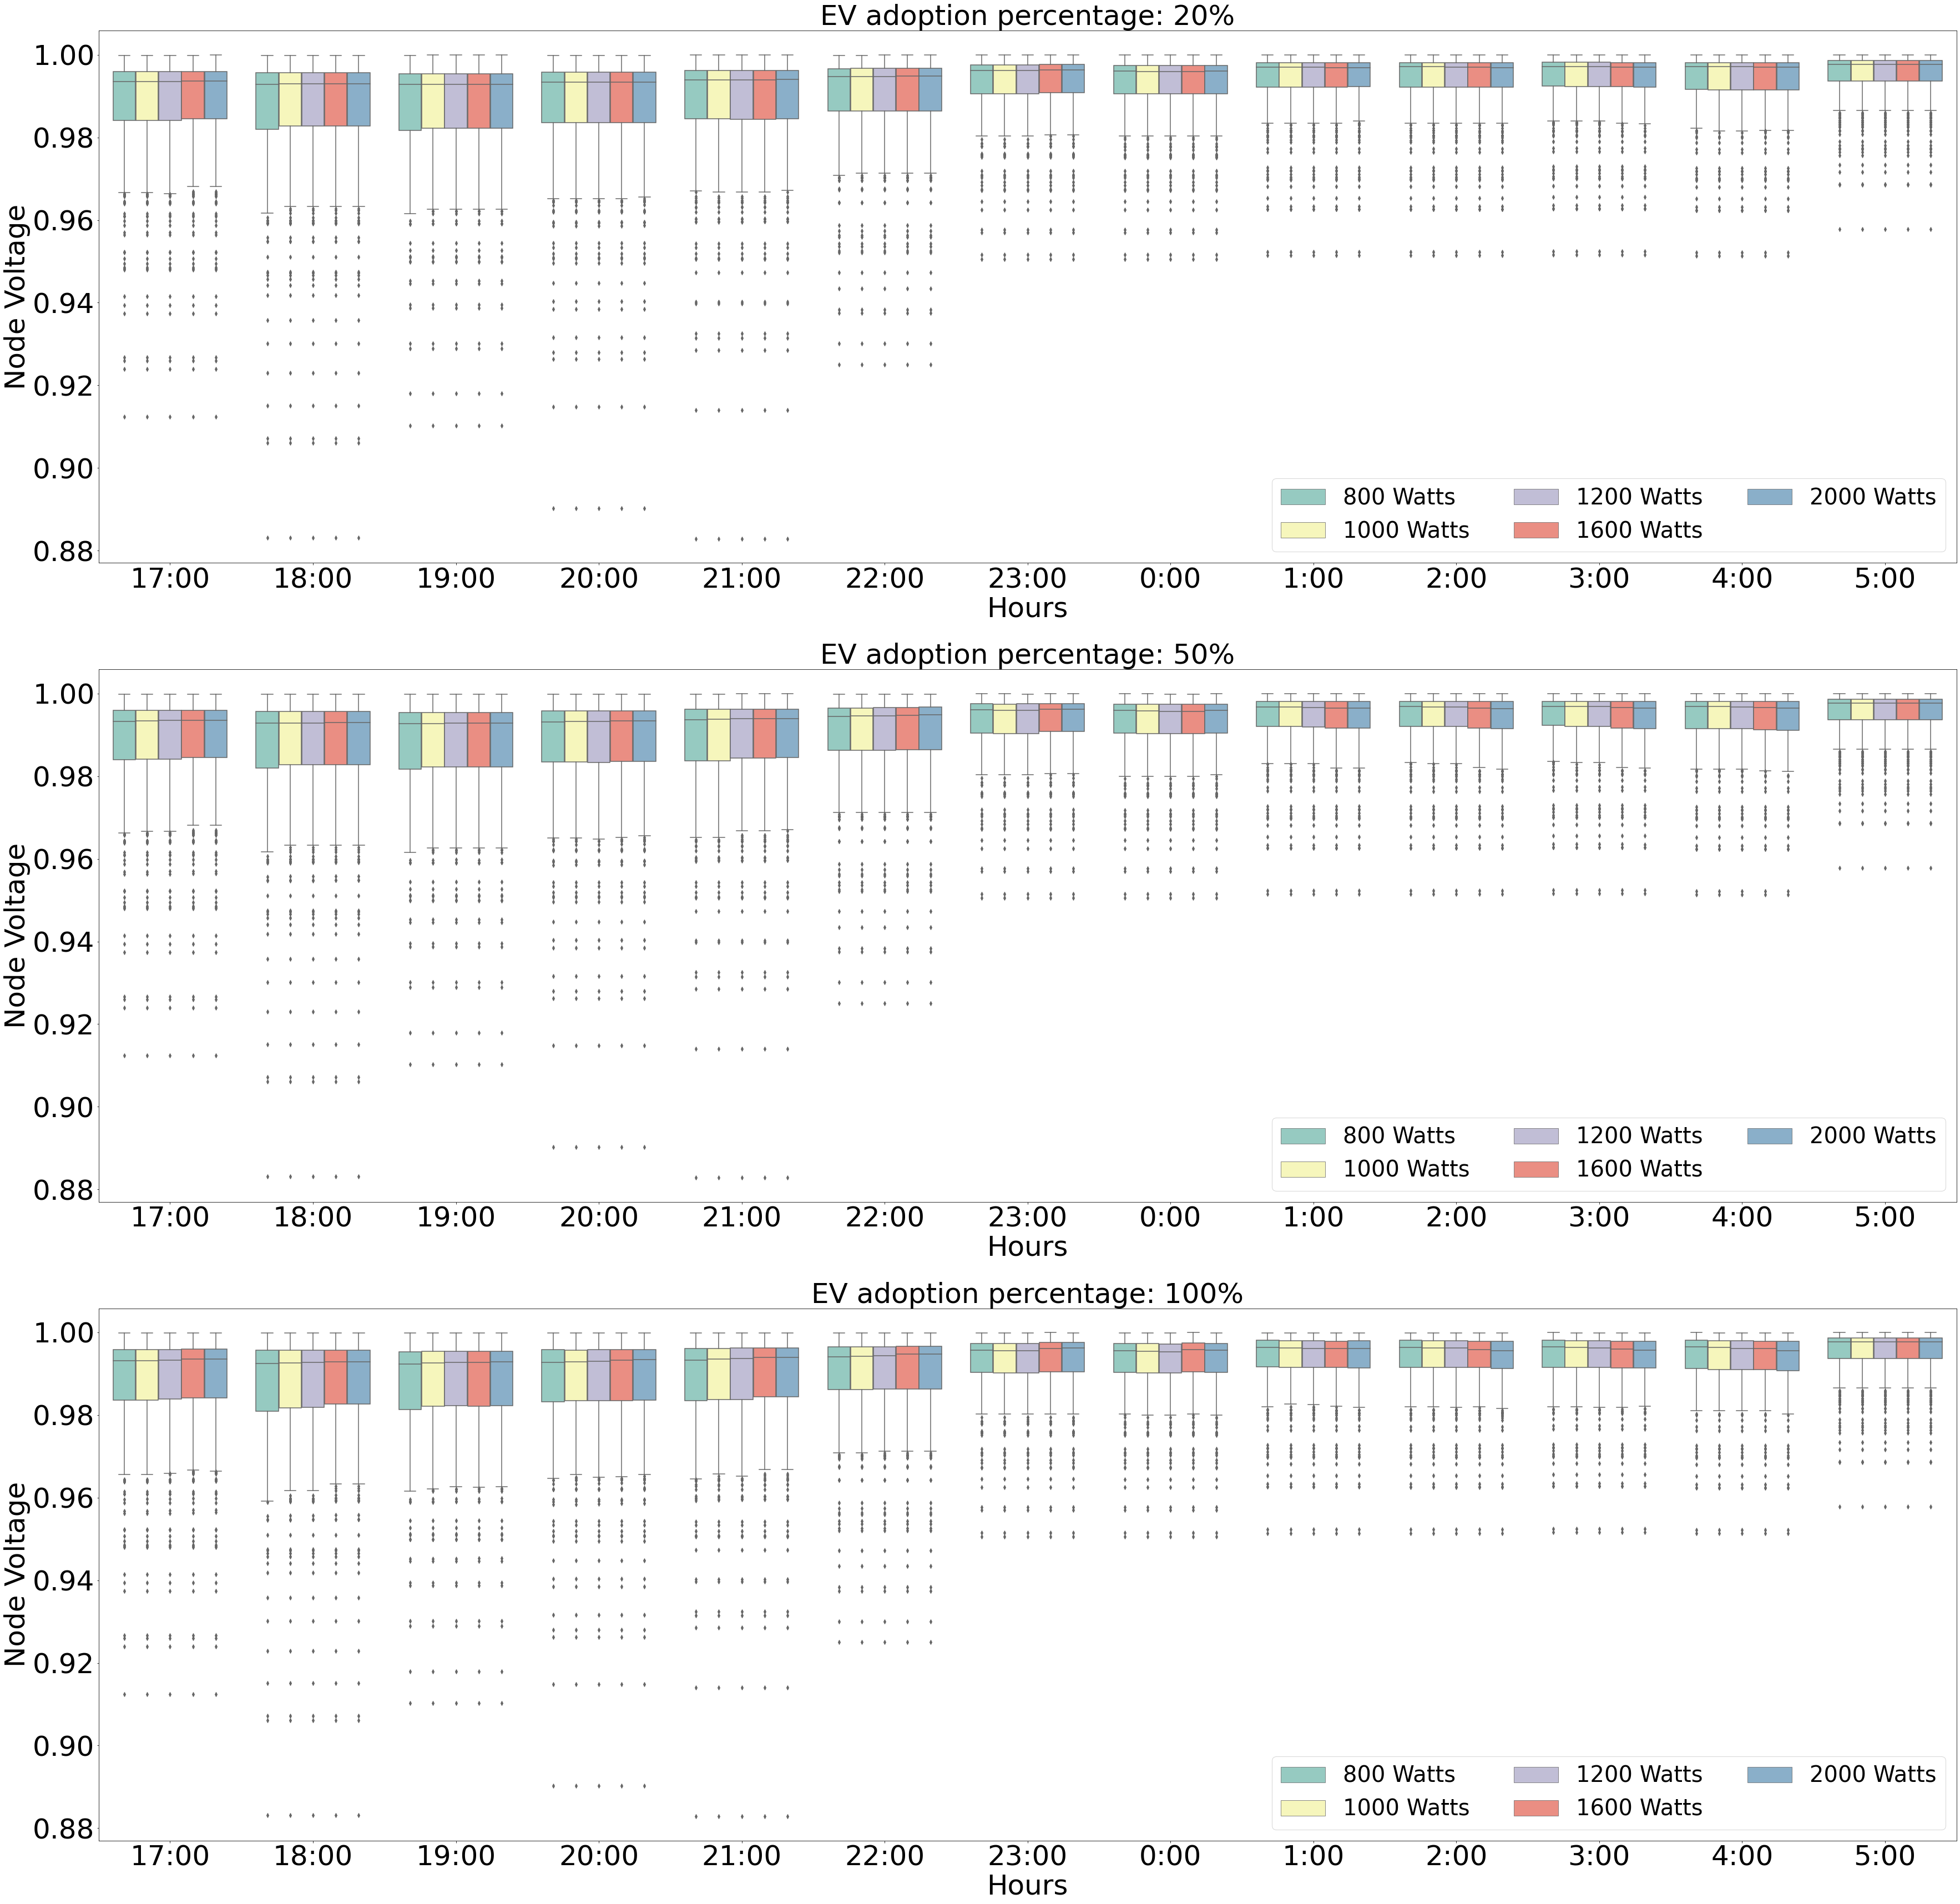

In [59]:
fig = plt.figure(figsize=(60,60),dpi=72)
for i,a in enumerate([20,50,100]):
    ax = fig.add_subplot(3,1,i+1)
    ax = compare_rating(a,ratings,dist,res_interest,
                        method='dist',ax=ax)

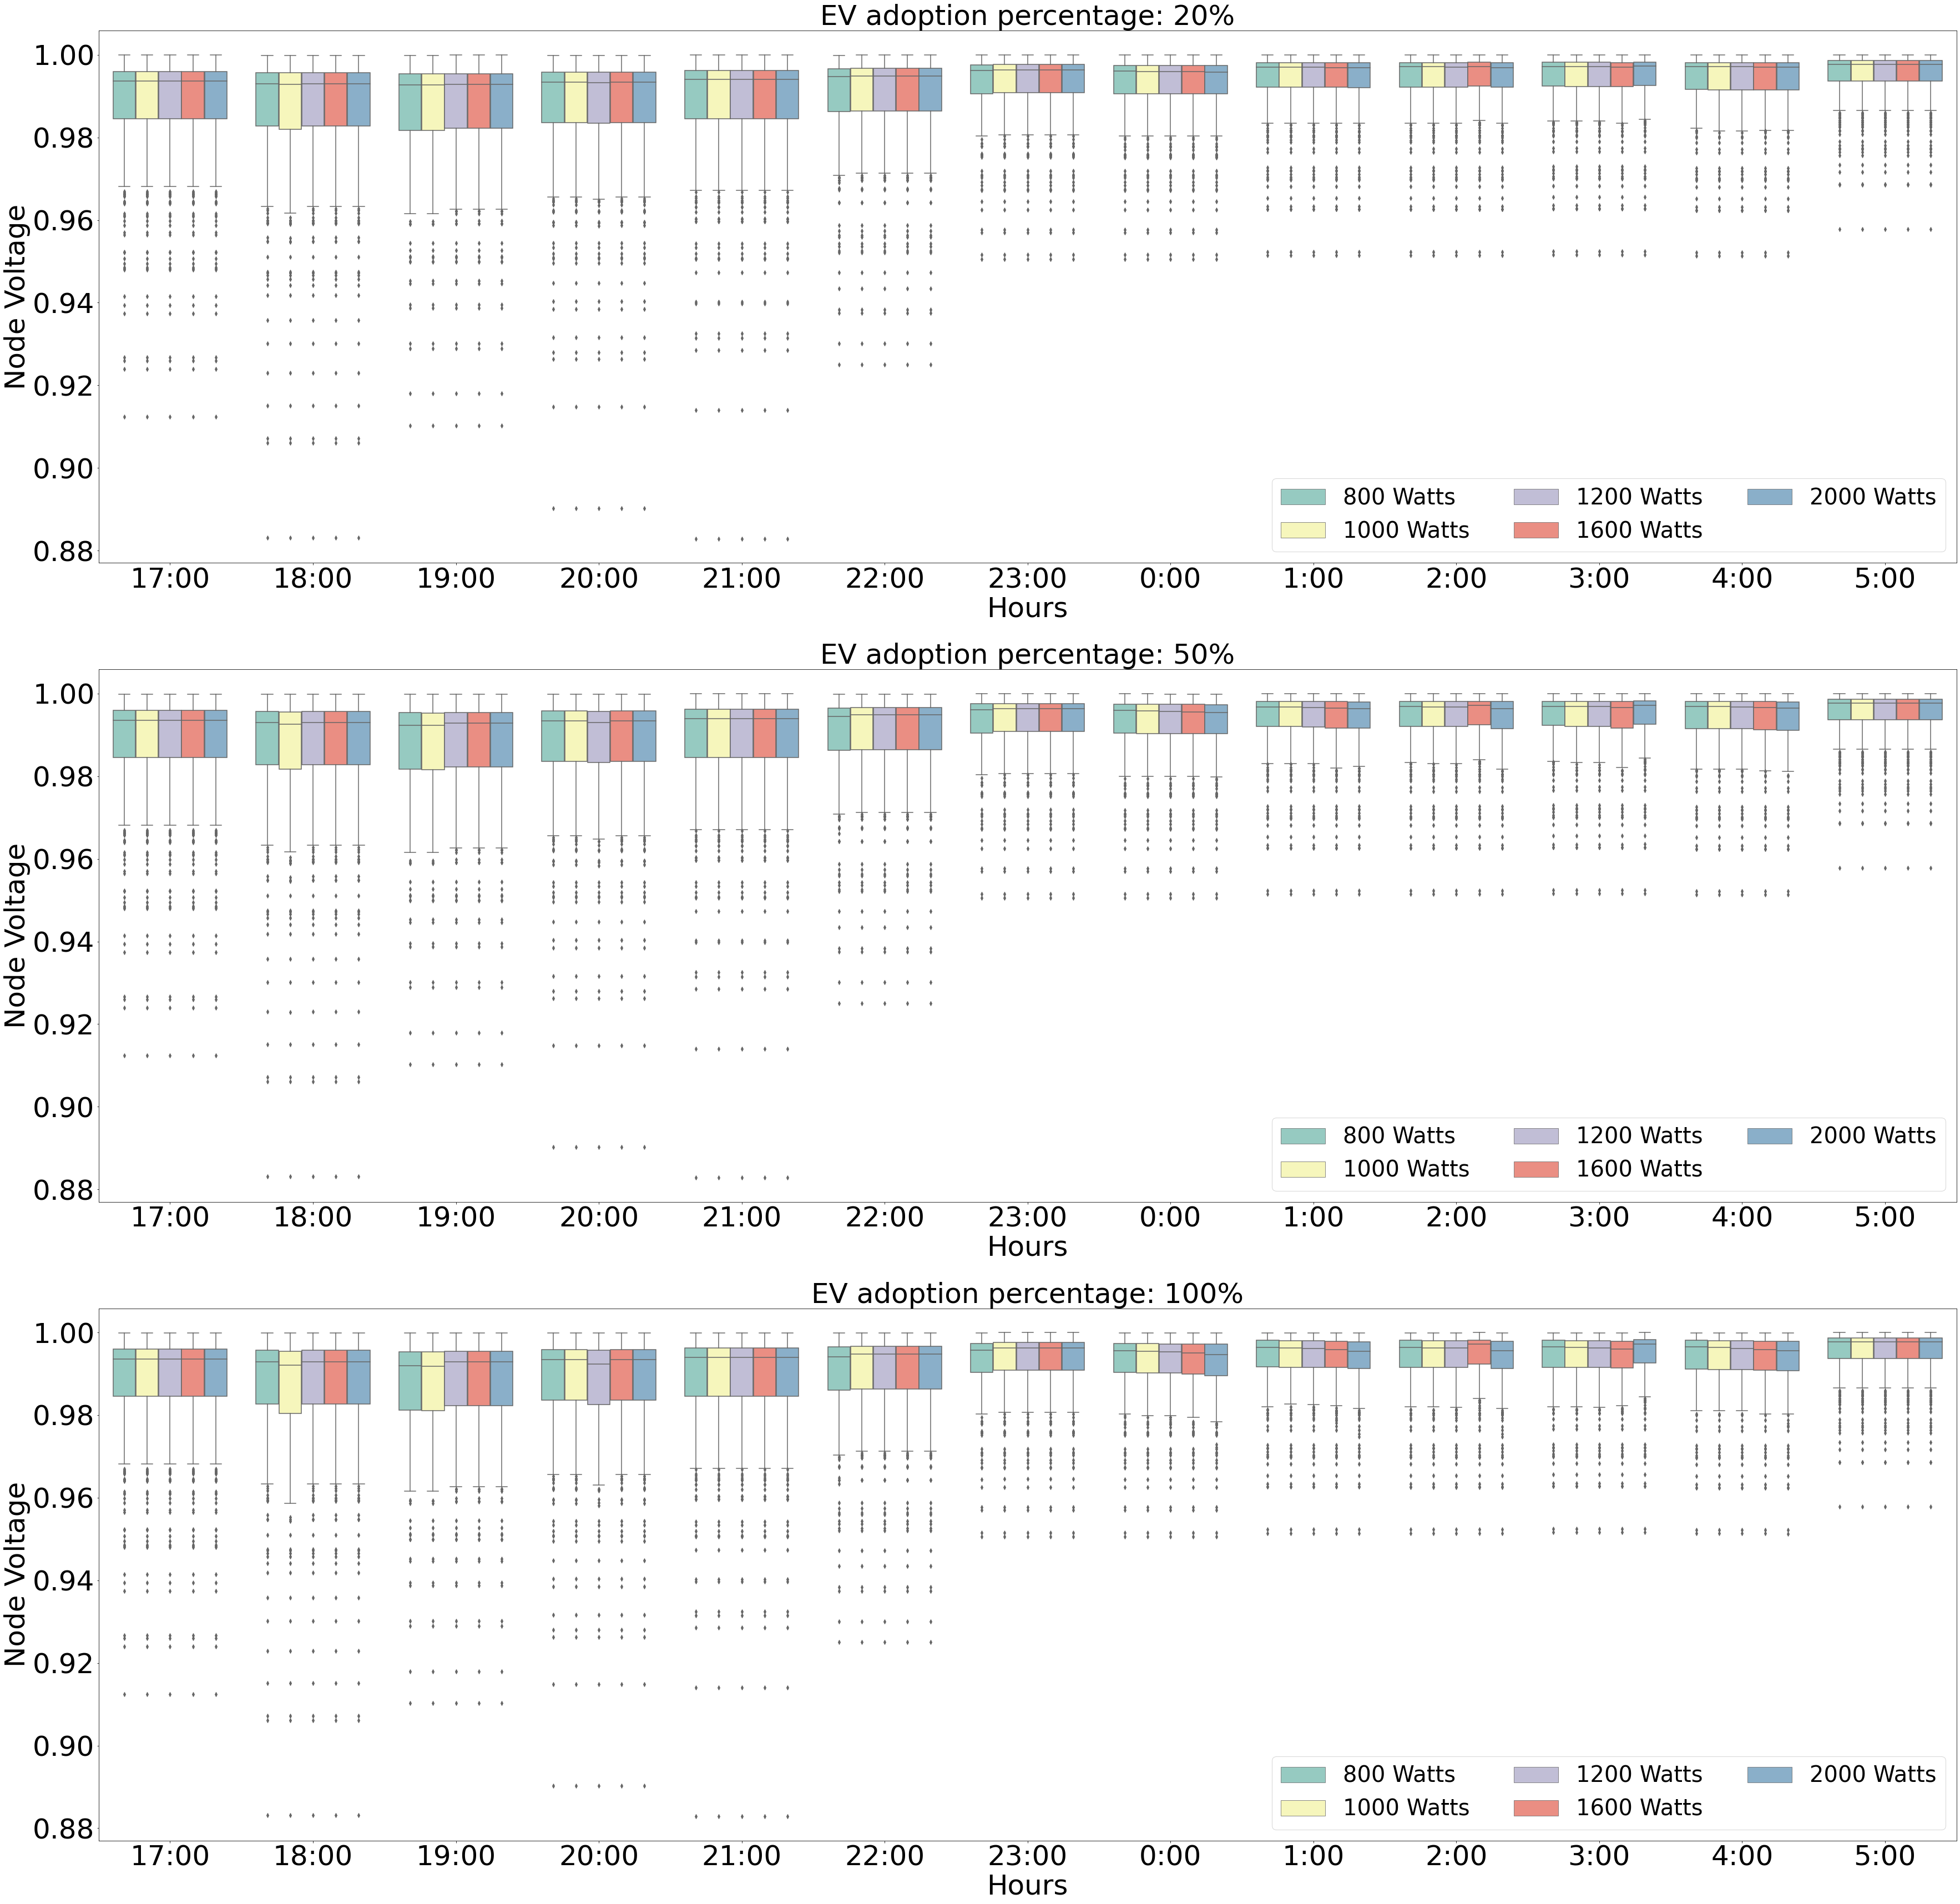

In [60]:
fig = plt.figure(figsize=(60,60))
for i,a in enumerate([20,50,100]):
    ax = fig.add_subplot(3,1,i+1)
    ax = compare_rating(a,ratings,dist,res_interest,
                        method='ind',ax=ax)

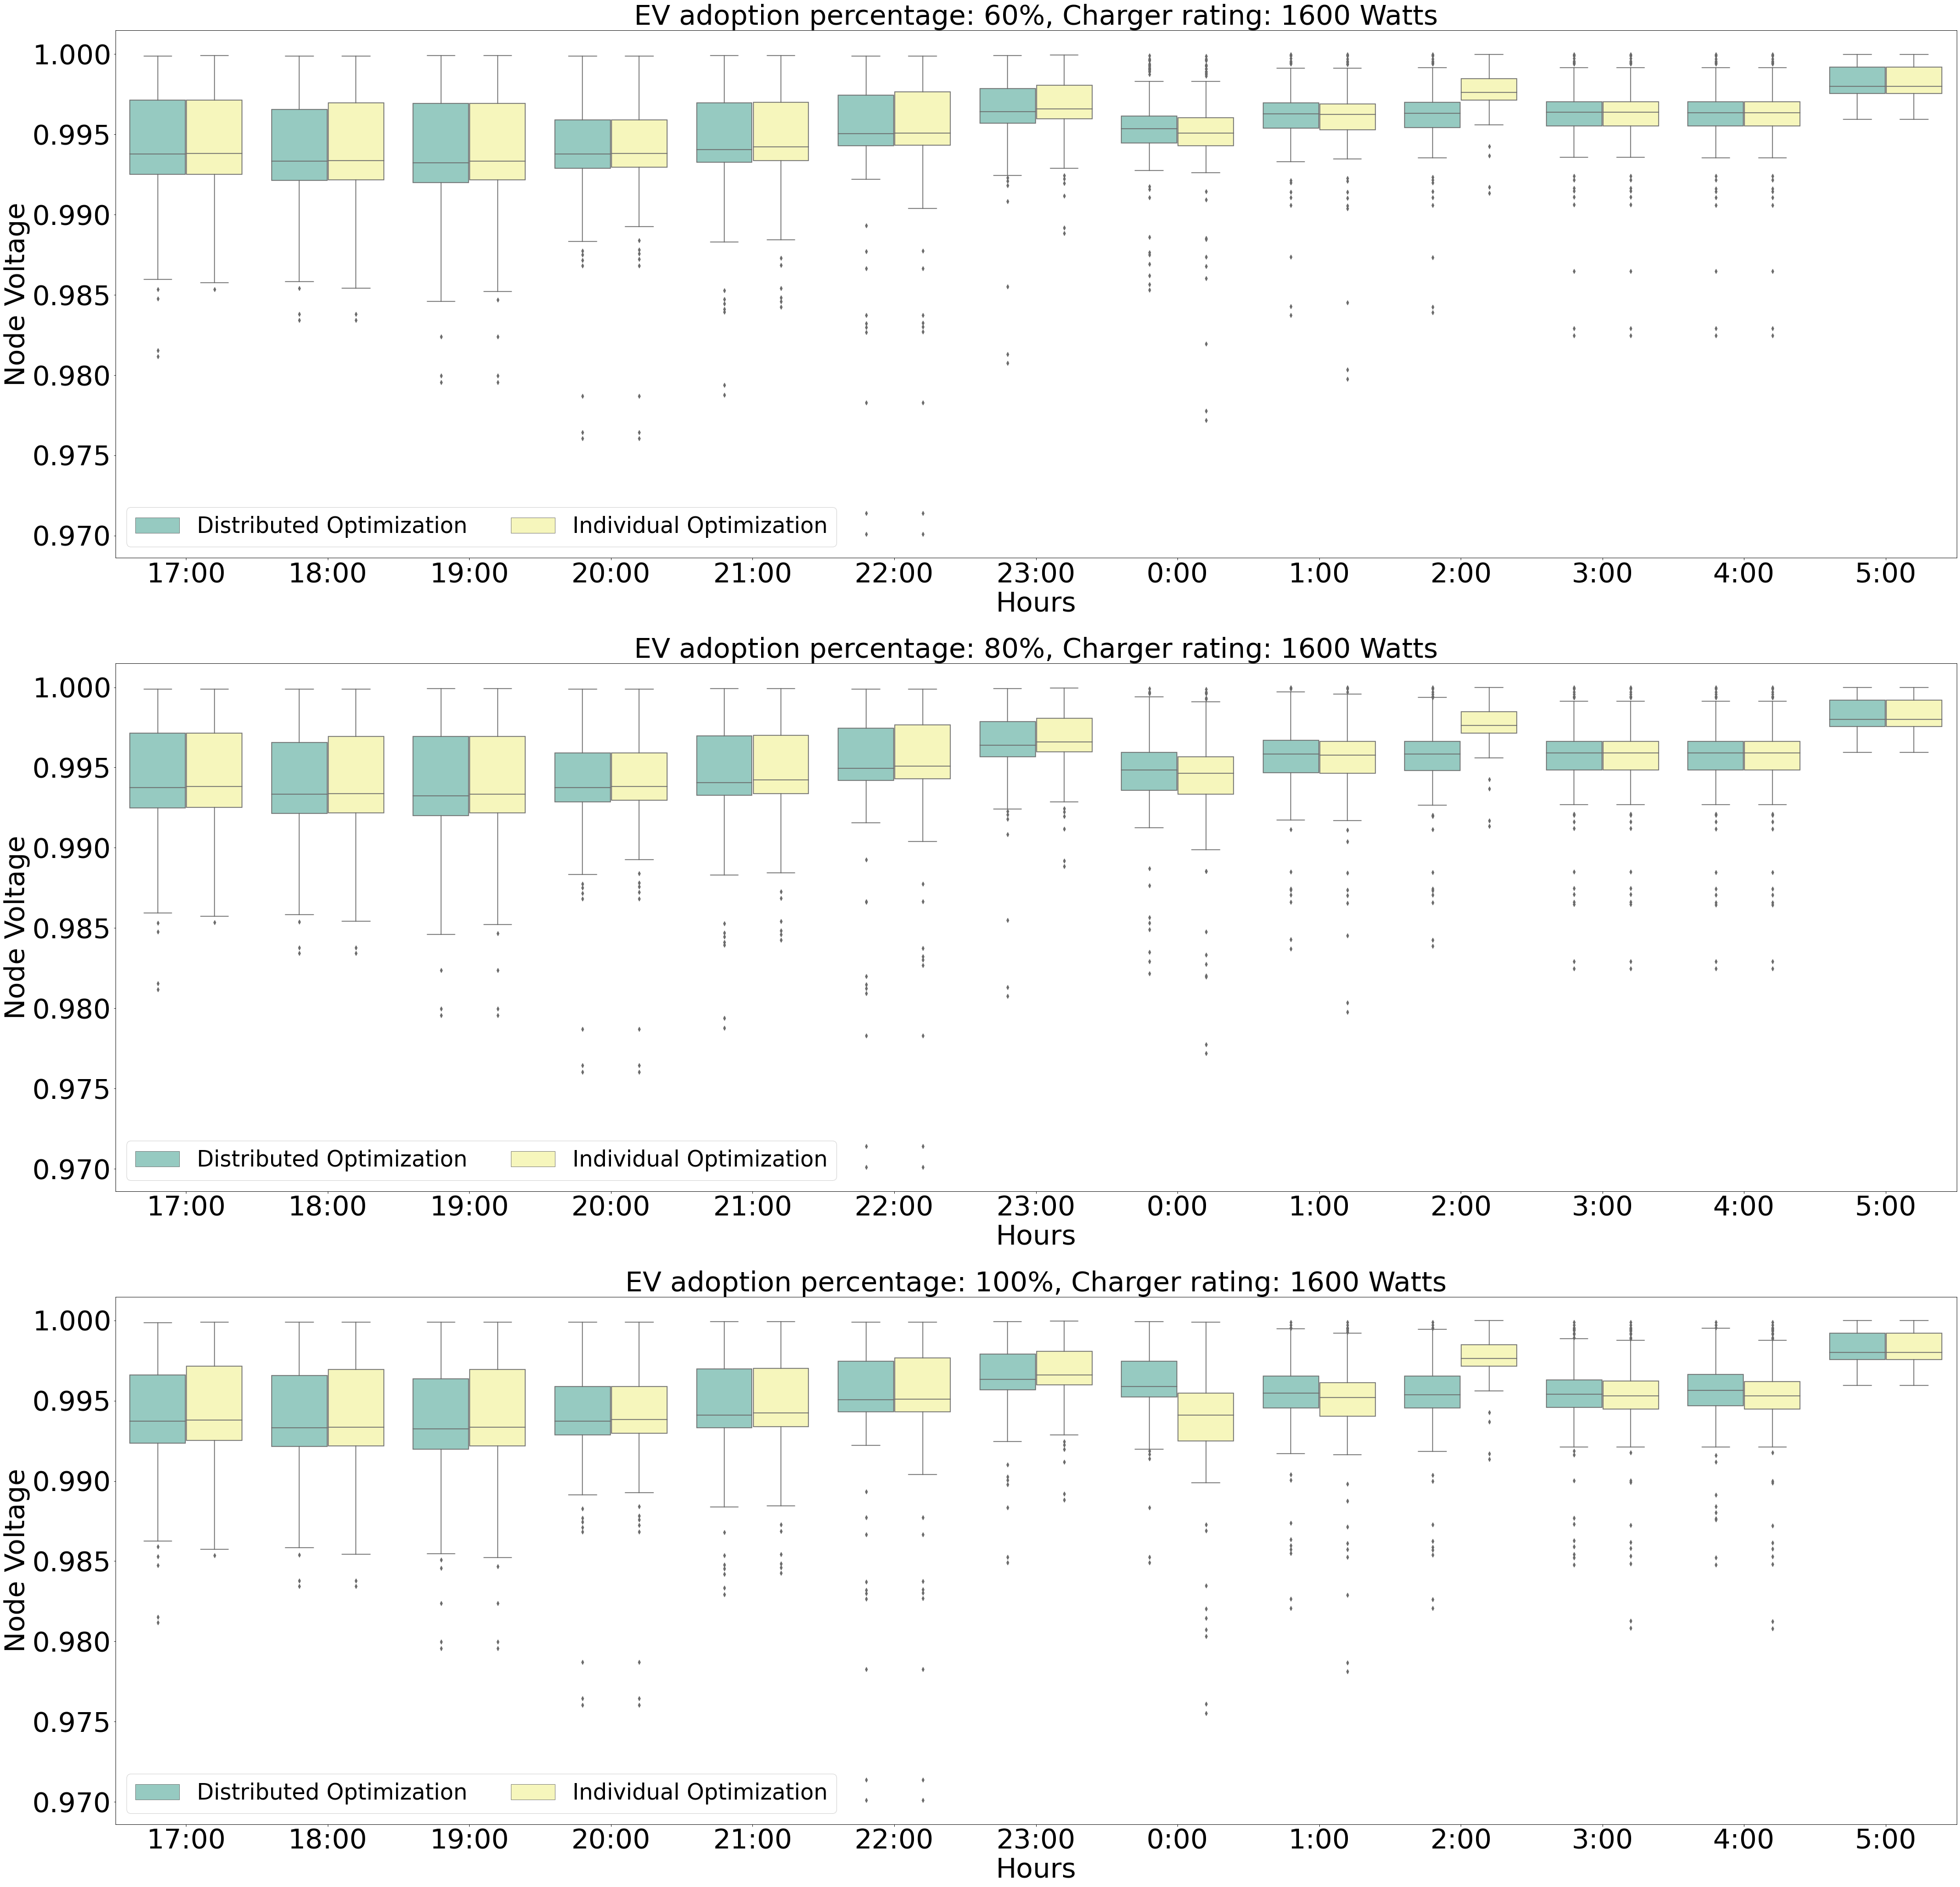

In [64]:
fig = plt.figure(figsize=(60,60))
r = 1600
for i,a in enumerate([60,80,100]):
    ax = fig.add_subplot(3,1,i+1)
    ax = compare_method(a,r,dist,res_interest,ax=ax)

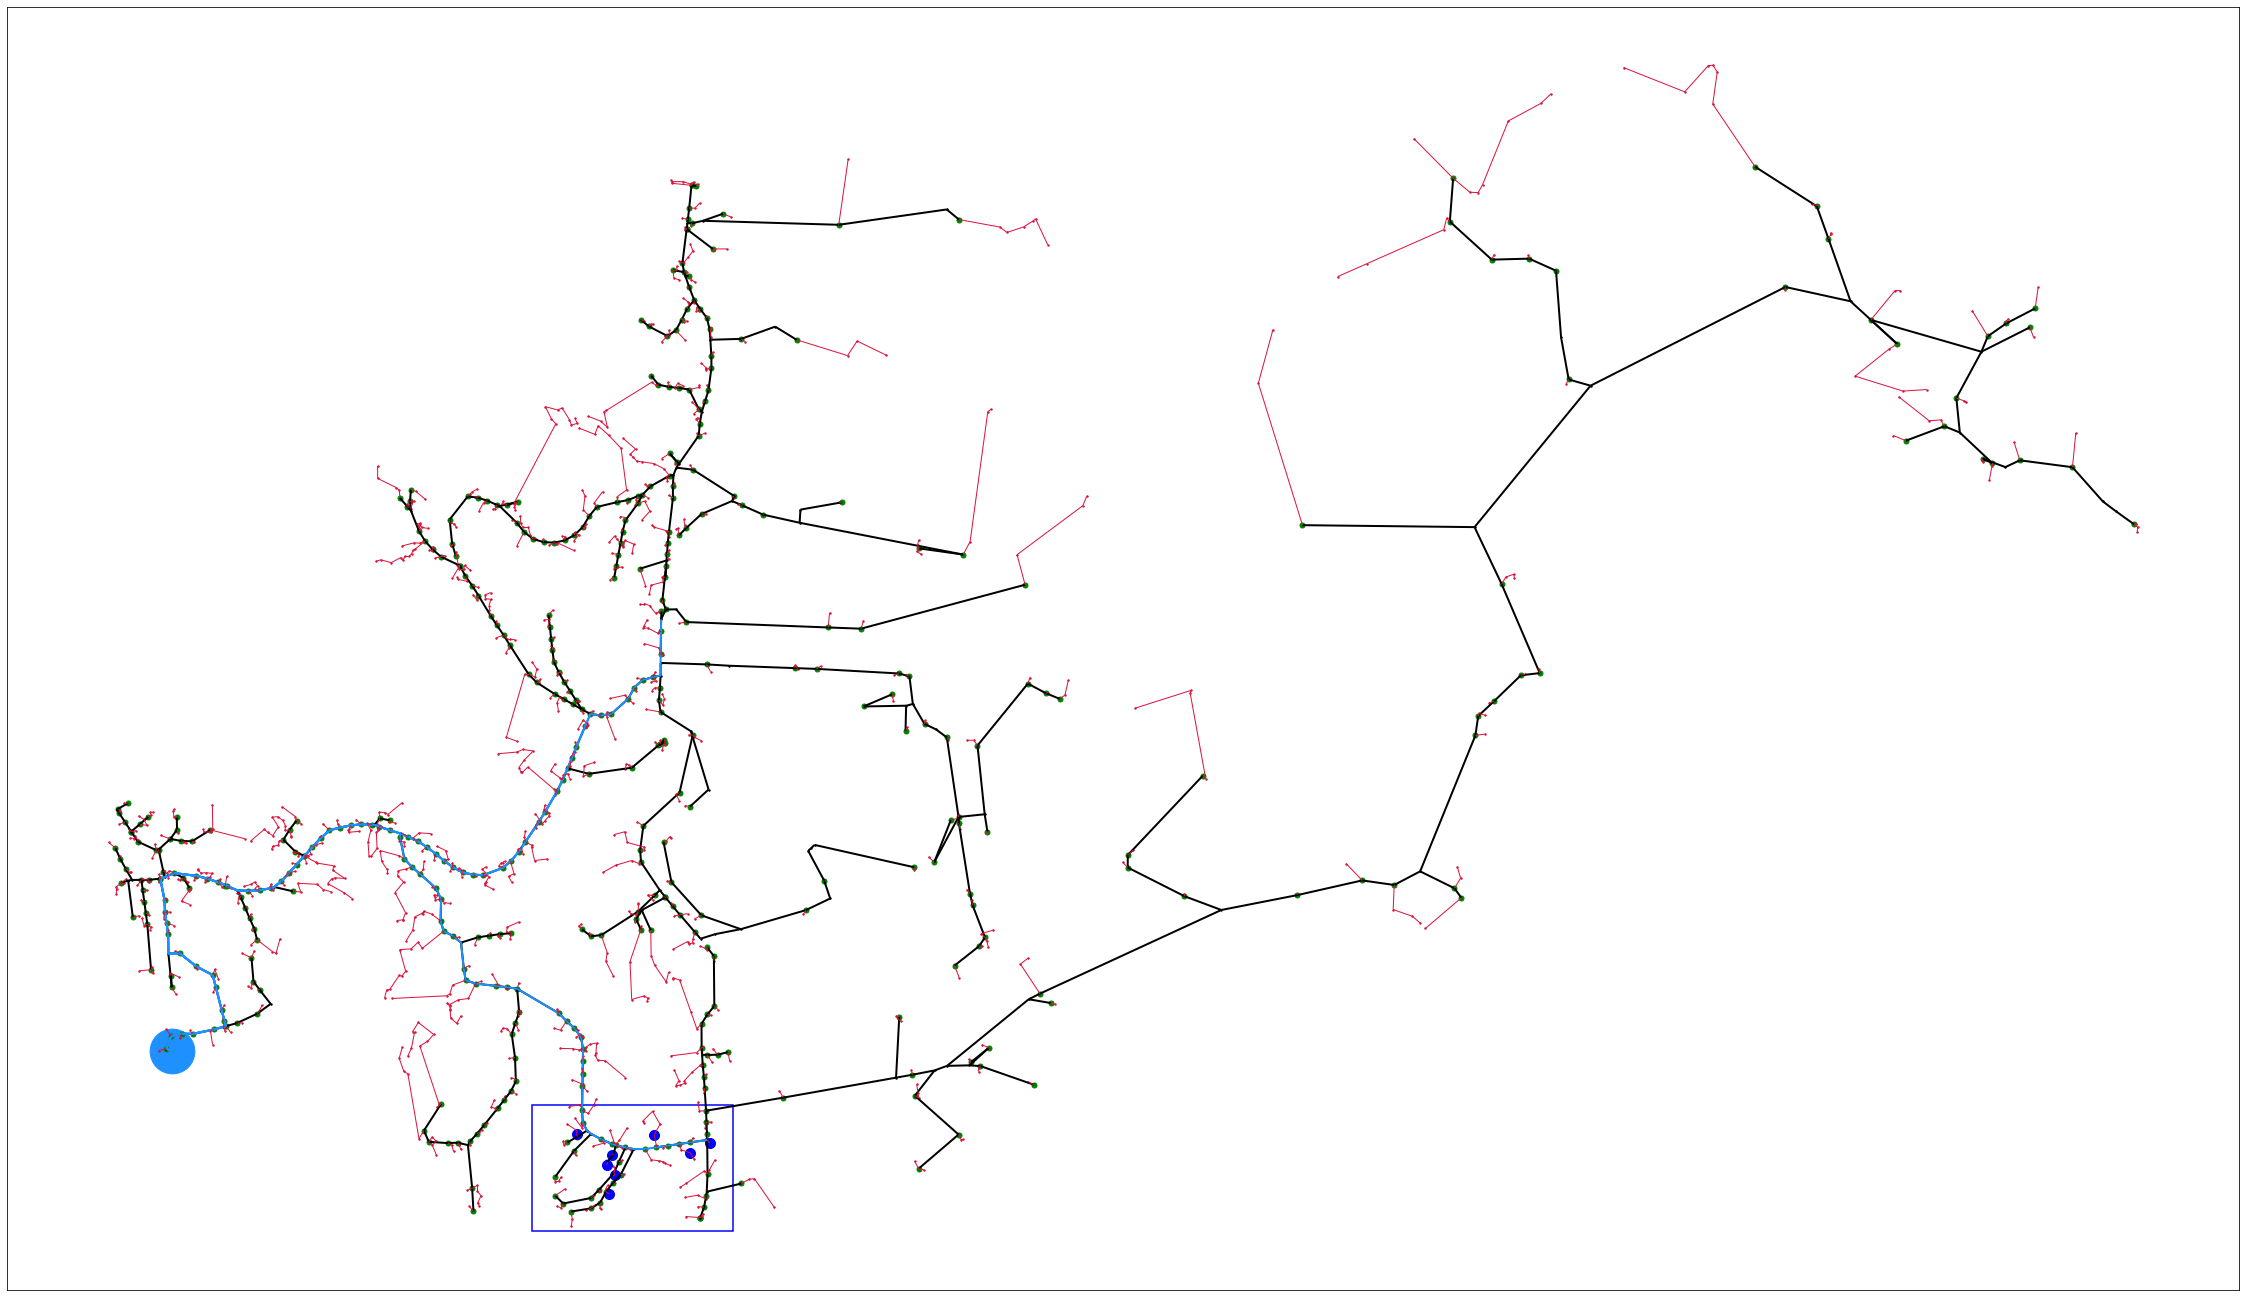

In [40]:
fig = plt.figure(figsize=(40,40), dpi=72)
ax = fig.add_subplot(111)
a=10
r=2000
prefix = "agentEV-"+str(a)+"-adopt"+str(int(r))+"Watts.txt"
with open(outpath+prefix,'r') as f:
    lines = f.readlines()
        
# Get EV adopter list
ev_homes = [int(x) for x in lines[5].split('\t')[1].split(' ')]
ax = plot_network(ax,dist,with_secnet=True,ev_home=ev_homes)


